# Text Analysis

---

## Introdution

Text Analysis is great for summarizing or getting useful information out of a large amount of text. 


## Glossary of Terms

* **Tokenize**
* **Stemming**
* **Unsupervisd Learning**
* **Supervised Learning**
* **Topic Modelling**
* **LDA**
* **Stop Words**

## Table of Contents
 - [Data Source](#Data-Source)
 - Data_Cleaning
 - Unsupervised Learning: Topic Modelling
 - Supervised Learning: LDA
 
 ---

In [1]:
%pylab inline 
import nltk
import ujson
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score
from collections import Counter
from nltk.corpus import stopwords
from nltk import SnowballStemmer

Populating the interactive namespace from numpy and matplotlib


## Data Source

In [2]:
def load_reddit(fname, ls_subreddits, MIN_CHAR=30):
    """
    Loads Reddit Comments from a json file based on 
    whether they are in the selected subreddits and 
    have more than the MIN_CHARACTERS
    
    Parameters
    ----------
    fname: str
        filename
    ls_subreddits: ls[str]
        list of subreddits to select from 
    MIN_CHAR: int
        minimum number of characters necessary to select
        a comment
        
    Returns
    -------
    corpus: ls[str]
        list of selected reddit comments
    subreddit_id: array[int]
        np.array of indices that match with the ls_subreddit
        index 
    """
    corpus = []
    subreddit_id = []
    with open(fname, 'r') as infile:
        for line in infile:
            dict_reddit_post =  ujson.loads(line)
            subreddit = dict_reddit_post['subreddit']
            n_characters = len( dict_reddit_post['body'] )
            if ( (subreddit in ls_subreddits) and (n_characters > MIN_CHAR) ):
                corpus.append(dict_reddit_post['body'])
                subreddit_id.append(ls_subreddits.index(subreddit))
    return corpus, np.array(subreddit_id)

In [3]:
ls_subreddits = ['SuicideWatch', 'depression']

In [4]:
[corpus, subreddit_id] = load_reddit('RC_2015-05.json', ls_subreddits, MIN_CHAR=30)

## Preprocess the data

In [5]:
RE_PREPROCESS = r'\W+|\d+' #matches are non-word chracters and digits to be replaced with digits.  

In [6]:
#get rid of punctuation and lowercase
processes_corpus = [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus]

In [7]:
Counter(subreddit_id)

Counter({0: 12609, 1: 24683})

# Tokenize and stem

In [ ]:
nltk.download('stopwords')
ANALYZER = "word"
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2)
MIN_DF = 0.01
MAX_DF = 0.8

In [8]:
vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=(0,2),
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akumar67/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
NORM = None
SMOOTH_IDF = True
SUBLINEAR_IDF = True
USE_IDF = True

In [19]:
transformer = TfidfTransformer(norm = NORM,
                               smooth_idf = SMOOTH_IDF,
                               sublinear_tf = True)

In [26]:
#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
bag_of_words = vectorizer.fit_transform( processes_corpus )
if USE_IDF:
    tfidf = transformer.fit_transform(bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 11.00s


# Superivsed Learning: Identify the Subreddit Section

In [58]:
#split the data into training and testing sets. 
#refactor this in the test train-split
train_set_size = int(0.8*len(subreddit_id))
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, 
                     len(subreddit_id))

In [59]:
print('Training Labels', Counter(subreddit_id[train_idx]))
print('Testing Labels', Counter((subreddit_id[test_idx])))

Training Labels Counter({1: 19382, 0: 10451})
Testing Labels Counter({1: 5301, 0: 2158})


In [67]:
X = tfidf

In [70]:
#make clear what are the features and what are the labels 
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(X[train_idx], 
              subreddit_id[train_idx])
y_score = mdl.predict_proba( X[test_idx])

In [76]:
#plot a histogram to see a distribution the probabilities


In [ ]:
#maybe plot an actual ROC curve as well to see the shape

In [77]:
auc = roc_auc_score( subreddit_id[test_idx], y_score[:,1])
print(auc)

0.649532263397


In [78]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

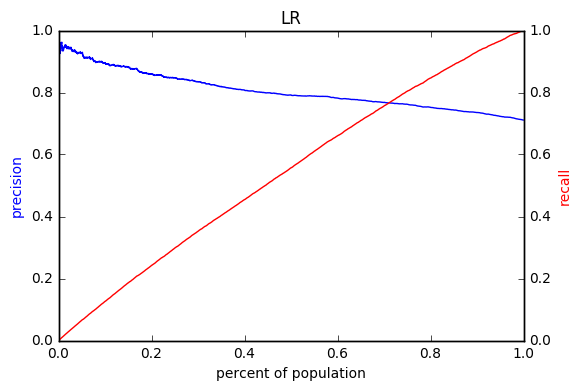

In [79]:
 plot_precision_recall_n(subreddit_id[test_idx], y_score[:,1], 'LR')

In [80]:
# the features in this case are the words most likely to be found in the passages 
# Let's examine the coefficients a bit more. 

In [88]:
coef = mdl.coef_[0]

In [90]:
coef_index = coef.argsort()

In [103]:
num_features = 5
subreddit1_features = [ features[i] for i in coef_index[-num_features:]] 
subreddit2_features = [ features[i] for i in coef_index[:num_features]]

In [107]:
#need to carefully explain how the 0 and 1 binary classifcation relateds the the subreddits and how to then use that
#to find the proper labels. 

In [109]:
#maybe do something with this crazy indexing: this is python not C!
num_comments = 5
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:] #last ten comments
subreddit2_comment_idx = y_score[:,1].argsort()[:num_comments]

In [112]:
subreddit1_comment_idx

array([4814, 5730, 3775, 6499,  706])

In [119]:
subreddit1_features

['helps', 'psychiatrist', 'depressed', 'effects', 'depression']

In [123]:
#these are the 5 comments the model is most sure of 
for i in subreddit1_comment_idx:
    print(u"""{}:{}\n-----------------------------------------------------------------------------\n{}
    ======================================================================================================""".format(
                    ls_subreddits[ subreddit_id[test_idx[i]]],
                      np.around(y_score[i,1], decimals=3),
                      corpus[test_idx[i]]))

depression:0.999
-----------------------------------------------------------------------------
Sure! I'm taking 50mg of sertraline which is a fairly low dose. I started out at 25mg, they increased me to 50mg and I started seeing improvements. I started on medication and decided to stick with it because I wanted to pass my semester. I had previously dropped out of school and I really wanted to finish my degree. I experience a lot of classroom anxiety so I would avoid going to class. On the sertraline, boom, anxiety in the classroom gone. It took me about 3 months to get to that point - so give your medication time to work.

I had no weight gain on the medication at all. In fact, it has probably helped my eating habits because I used to binge eat when I was very depressed. I have since stopped doing that. 

The side effects I do experience are issues acheiving orgasm. Possible TMI but last time I attempted an orgasm it took me 45 minutes! I still experience sexual satisfaction with my pa

In [125]:
for i in subreddit2_comment_idx:
    print(u"""{}:{}\n-----------------------------------------------------------------------------\n{}
    ======================================================================================================""".format(
                    ls_subreddits[ subreddit_id[test_idx[i]]],
                      np.around(y_score[i,1], decimals=3),
                      corpus[test_idx[i]]))

SuicideWatch:0.01
-----------------------------------------------------------------------------
It sounds like you're exhausted on many levels and are losing hope or have lost hope. I'm so sorry. 

For what it's worth, it's striking that you give equal weight in your post to your personal struggles and your existential despair at the state of the world. That's pretty remarkable - it speaks to your empathy. You are not worthless. I think that you want to help people. You say that you don't even know why you try - but it sounds like you do know. You care about the world so much that it hurts. Helping people gives life meaning, right? And sometimes jerks may deny that or try to take that from you, but we all have to fight them. 

I know that I can't imagine the added pain of being trans in a hostile world, though some of this, I get. I'm queer too and not in a good situation right now and it sounds like you've got something eating disordered type stuff going on - that certainly makes the 

# Unsupervised Learning 

In [ ]:
N_TOPICS = 50
N_TOP_WORDS = 10 

def load_all_reddit_mh( directory = '2015', filenames = ['RC_2015-01', 'RC_2015-02', 
                                    'RC_2015-03', 'RC_2015-04', 'RC_2015-05'], MIN_CHARACTERS = 50):
    """
    Function to import Reddit comments from mental health forums from May 2015 
    
    params: 
        str filename: name of file to open 
        int MIN_CHARACTERS: thresholds comments we load by comment length (in characters) 
    """
    corpus = []
    subreddit_id = []
    subreddits = []
    for filename in filenames: 
        with open(directory + '/' + filename, 'r') as f:
            for line in f:
                json_dict = ujson.loads(line)
                subreddit = json_dict['subreddit']
                comment = json_dict['body']
                if len(comment) > MIN_CHARACTERS:
                    corpus.append(comment)
                    if subreddit in subreddits:
                        pass
                    else: 
                        subreddits.append(subreddit)
                    subreddit_id.append(subreddits.index(subreddit))
    return [corpus, subreddit_id, subreddits]


In [ ]:
start = time.time()
[corpus_all, subreddit_id_all, subreddits_all] = load_all_reddit_mh(directory = '.', filenames = ['RC_2015-05.json'],
                                                                    MIN_CHARACTERS = MIN_CHARACTERS)

# Get rid of punctuation and set to lowercase  
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

bag_of_words_all = vectorizer.fit_transform( processed_corpus_all )
end = time.time() 
print("Processing took {}s".format(end - start)) # takes ~62s for 1 file, 401s for 5 files 

In [ ]:
print(Counter(subreddit_id_all), len(subreddit_id_all))

In [ ]:
start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
lda.fit_transform( bag_of_words_all )
end = time.time() 
print("Processing took {}s".format(end- start)) # takes ~72s for 1 file, ~445s for 5 files 

In [126]:
def timer():
    start = time.time()
    yield
    end = time.time()
    print(end-start)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx, ", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("\nTopics in LDA model:")

print_top_words(lda, features, N_TOP_WORDS)

# The Comments Most Likely to be taken from each subreddit

Return to [TOC](#Table-of-Contents)